##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### References
- https://www.tensorflow.org/tutorials/text/transformer
- https://github.com/jungyeul/korean-parallel-corpora
- https://wikidocs.net/31379

# Transformer를 이용하여 한국어를 영어로 번역하기

"Attention Is All You Need" 논문이 제안한 Transformer 모델을 이용해 한국어를 영어로 바꾸는 모델을 학습합니다.

Transformer의 핵심 아이디어는 self-attention입니다. Self-attention은 입력 시퀀스의 벡터 표현을 계산하기 위해 입력 시퀀스 단어의 여러 위치에 대해 attention을 계산합니다. Transformer는 여러겹의 self-attention 층으로 구성되어 있고 "scaled-dot product attention", "Multi-head attention"에서 자세히 설명할 것입니다.

Transformer의 장점과 단점은 다음과 같습니다.

장점

* 문장 내의 단어들이 병렬로 계산됩니다. Transformer는 모든 연산을 matrix 형태로 한 번에 처리할 수 있지만 RNN의 경우에는 매 time-step마다 순서대로 출력값을 계산하기 때문에 연산의 효율성이 떨어집니다.
* 멀리 떨어져 있는 입력 값도 모든 출력 값에 영향을 줄 수 있습니다. RNN의 경우는 멀리 떨어져 있는 입력 값에 대한 영향이 점점 떨어지기 때문에 long-range dependency를 학습하기 힘듭니다. 하지만 Transformer는 아무리 멀리 떨어져 있어도 그 입력에 대한 attention을 계산할 수 있기 때문에 long-range dependency를 훨씬 잘 학습할 수 있습니다. 

단점

* 시계열 데이터의 경우 특정 time-step의 출력값이 항상 모든 과거 정보를 이용해 계산되기 때문에 최근 값이 더 중요한 경우에 대해서는 효율성이 떨어질 수도 있습니다. 최근이 중요함에도 불구하고 계속 전체 과거 정보를 이용하기 때문입니다.


<img src="./images/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        

4 Physical GPUs, 1 Logical GPUs


## 입력 파이프라인 설정

한국어 뉴스를 영어로 번역하는 데이터셋을 불러옵니다. 이 데이터는 약 90000개의 훈련 데이터로 구성되어 있습니다.

reference: https://github.com/jungyeul/korean-parallel-corpora

In [4]:
dataset_dir = './data/korean-english-news-v1'
en_fname = 'korean-english-park.train.en'
kr_fname = 'korean-english-park.train.ko'

f = open('{}/{}'.format(dataset_dir, en_fname))
en = f.readlines()

f = open('{}/{}'.format(dataset_dir, kr_fname))
kr = f.readlines()

train_dataset = np.c_[kr, en]
del kr, en

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)

훈련 데이터셋에서 subword tokenizer를 생성합니다. tokenizer는 문장을 단어별로 분리해주는 역할을 합니다.

**Note**: Tokenizing 과정이 몇분 정도 소요되기 때문에 본 튜토리얼에서는 사전에 tokenizing된 pickle 파일을 불러오겠습니다.

In [5]:
'''
%%time
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for kr, en in train_dataset), target_vocab_size=2**13)

tokenizer_kr = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (kr.numpy() for kr, en in train_dataset), target_vocab_size=2**13)
'''

import bz2
import _pickle

with bz2.BZ2File('tokenizer.pbz2', 'rb') as f:
    tokenizer_en, tokenizer_kr = _pickle.load(f)

In [6]:
sample_string = '트랜스포머 좋습니다!'

tokenized_string = tokenizer_kr.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_kr.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [141, 1038, 3174, 5155, 1809, 276, 7961]
The original string: 트랜스포머 좋습니다!


Tokenizer는 문장을 subword 단위로 encoding 합니다. 만일 단어가 tokenizer의 dictionary에 없으면 더 작은 단위로 쪼갭니다.

In [7]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_kr.decode([ts])))

141 ----> 트
1038 ----> 랜
3174 ----> 스포
5155 ----> 머 
1809 ----> 좋
276 ----> 습니다
7961 ----> !


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
tokenizer_kr.vocab_size # Korean word index: 0~8183

8184

In [10]:
print(tokenizer_en.vocab_size) # English word index: 0~8151

8152


모델에 문장의 시작과 끝을 알려주기 위해 start token과 end token을 추가합니다.

In [11]:
# Korean start token: 8184, Korean end token: 8185
# English start token: 8152, English end token: 8153
def encode(lang1, lang2):
  lang1 = [tokenizer_kr.vocab_size] + tokenizer_kr.encode(
      lang1.numpy()) + [tokenizer_kr.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

`Dataset.map` 을 이용해 'encode' 함수를 적용해야 하지만 `Dataset.map`은 graph mode에서만 작동합니다. 

* 그래프 텐서는 값을 가지지 않습니다. 그래프만 만들고 나중에 값을 대입합니다.
* 그래프 모드에서는 Tensorflow에 내장되어 있는 연산이나 함수만 쓸 수 있습니다.

따라서 '.map'을 이용해 'encode' 함수를 바로 적용할 수 없습니다. `tf.py_function`을 이용해 'encode'함수를 감싸야 합니다. `tf.py_function`는 텐서를 'encode' 함수의 입력값으로 쓰일 수 있도록 해줍니다.

In [12]:
def tf_encode(lang):
  result_kr, result_en = tf.py_function(encode, [lang[0], lang[1]], [tf.int64, tf.int64])
  result_kr.set_shape([None])
  result_en.set_shape([None])

  return result_kr, result_en

학습 속도 향상을 위해 토큰 길이가 40을 넘는 예제는 버립니다.

In [13]:
MAX_LENGTH = 40

In [14]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [15]:
# sos + encoded tocken + eos
train_dataset = train_dataset.map(tf_encode)
# 토큰 길이 40 이상의 토큰 필터링
train_dataset = train_dataset.filter(filter_max_length)

In [16]:
# Encoding 후, sos, eos가 잘 붙었는지, 토큰 길이가 40 미만인지 dataset을 확인합니다.
def print_dataset(dataset, num_print):
    iterator = iter(dataset)
    for i in range(num_print):
        kr, en = iterator.get_next()
        print('idx of data: {}\nkr shape: {}\nkr data: {}\nen shape: {}\nen data: {}\n'.format(i, kr.shape, kr, en.shape, en))

print_dataset(train_dataset, 10)

idx of data: 0
kr shape: (23,)
kr data: [8184 3050  793 1882  832    2 2421 7960 1319   92   91   36 4496 2893
  453   27  781  737 2612 7991 7962 7938 8185]
en shape: (18,)
en data: [8152 1122  492    5 2240 4444 2297   89   14 1906   38  111  133  249
 3016 7959 4353 8153]

idx of data: 1
kr shape: (30,)
kr data: [8184  222  519   75 3837   23 7398 7960   16    3  519   75 3837   31
 1027  532 2452  929    7   75 3837 7960  432 6094 1166   16  118  729
    1 8185]
en shape: (36,)
en data: [8152  184    7 5747 7928    7  503  845 1374   53    7 1283  892 7557
  484 4024  357  667 3105 7928 5460   33 1437    8  315 1283  892 7557
  758    2 4024  357 5460 7997    3 8153]

idx of data: 2
kr shape: (13,)
kr data: [8184   88 2724  215 1027  121   31 1166   16  118  729    1 8185]
en shape: (22,)
en data: [8152  606  713  100  667 3105 7928 3872 7997    2  103   34   66 1557
 7935   43  592    7 1333 8003    3 8153]

idx of data: 3
kr shape: (19,)
kr data: [8184 7962  688  112 2549    6 17

In [17]:
# 학습 데이터셋을 빠르게 읽기 위해 캐시작업을 합니다.
train_dataset = train_dataset.cache()

# 배치로 학습하기 위해서는 문장의 길이를 같게 해야 합니다. 하지만 실제 입력 문장의 길이는 모두 다릅니다.
# 따라서 배치 안에서 동일한 문장 길이를 유지하기 위해 padding을 합니다 보통 문장 뒤에 0을 삽입하여
# 문장의 길이를 맞춰줍니다.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

In [18]:
# Optional
# prefetch를 함으로써 현재 batch를 processing 하는동안 다음 batch를 준비합니다.
# 이 과정은 추가적인 메모리를 요구하지만, latency와 throughput을 높여줍니다.
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
print_dataset(train_dataset, 10)

idx of data: 0
kr shape: (64, 39)
kr data: [[8184    3 5141 ...    0    0    0]
 [8184  272 1127 ...    0    0    0]
 [8184  215  241 ...    0    0    0]
 ...
 [8184 3161    7 ...    0    0    0]
 [8184 3025 7960 ...    0    0    0]
 [8184 4488 1776 ...    0    0    0]]
en shape: (64, 40)
en data: [[8152   11 2458 ...    0    0    0]
 [8152   11  252 ...    0    0    0]
 [8152  333   47 ...    0    0    0]
 ...
 [8152   11 3453 ...    0    0    0]
 [8152 7930 6465 ...    0    0    0]
 [8152  704   14 ...    0    0    0]]

idx of data: 1
kr shape: (64, 39)
kr data: [[8184 7385 7960 ...   40    1 8185]
 [8184  693  111 ...    0    0    0]
 [8184  272  479 ...    0    0    0]
 ...
 [8184  150  544 ...    0    0    0]
 [8184  977  500 ...    0    0    0]
 [8184 6813  464 ...    0    0    0]]
en shape: (64, 40)
en data: [[8152  170 4891 ...   37    3 8153]
 [8152   11  630 ...    0    0    0]
 [8152 7480 1218 ...    0    0    0]
 ...
 [8152    1 1812 ...    0    0    0]
 [8152 1015  147 ...

## Positional encoding

Transformer는 문장을 순서대로 넣는 것이 아니라 한 번에 병렬로 처리하기 때문에 단어의 순서에 대한 정보가 별도로 주어져야 합니다. embedding vector에 positional encoding vector를 더해 줌으로써 한 문장 내의 단어들의 위치에 대한 정보를 추가합니다. embedding vector는 단어들의 상대적인 위치를 반영하지 않습니다. positional encoding을 통해 문장 내에 거리가 가까운 단어들이 좀 더 비슷한 vector를 가지도록 조정합니다. 다음의 함수를 이용해 positional encoding을 시행합니다.
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

<img src="./images/positional_encoding(1).png" width="500" alt="Positional-Encoding">

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


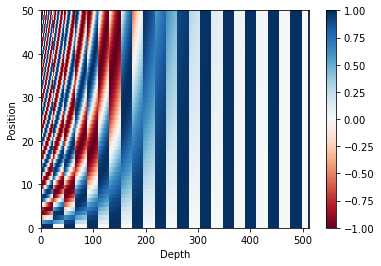

In [22]:
pos_encoding = positional_encoding(50, 512) # (1, 50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

같은 배치내에 있는 문장의 길이를 일치시키기 위해 padding을 이용했습니다. 하지만 이는 실제 입력이 아니기 때문에 입력에서 padding을 제거해야 합니다. masking을 이용해 padding을 가려줌으로써 모델이 padding을 입력으로 인식하지 못하도록 합니다. 여기서 padding에 해당하는 숫자는 0입니다. 따라서 0이 나타나는 부분을 masking을 이용해 가려줍니다. 

In [23]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # 추후 multi-head attention에 이를 이용할 것이므로 차원 2개를 중간에 추가해줍니다. 

  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [24]:
# masking으로 가리는 부분을 1, 아니면 0
x = tf.constant([[7, 6, 0, 0, 1],
                 [1, 2, 3, 0, 0],
                 [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

번역 결과를 학습하기 위해서는 타겟 이전의 단어들만 고려해야 합니다. 그 이유는 학습 후에 번역된 문장을 만들기 위해서는 단어를 앞에서부터 뒤로 순서대로 생성해야 하기 때문입니다. 즉 앞에서 뒤로 단어를 순서대로 만들 수 있는 모델을 학습하기 위해서는 타겟 이후의 단어들을 고려하면 안 됩니다. 예를 들면 세 번째 단어를 예측하기 위해서는 첫 번재, 두 번째 단어만을 보고 예측합니다. 따라서 네 번째, 그리고 그 이후의 단어들을 가려야 합니다. 

In [25]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [26]:
# masking으로 가리는 부분을 1, 아니면 0
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="./images/scaled_attention.png" width="500" alt="scaled_dot_product_attention">
<img src="./images/scaled_attention(2).png", width="500", alt="scaled_dot_product_attention(2)">

Attention을 계산하기 위해서는 Q (query), K (key), V (value) 세 가지 요소가 필요합니다. 다음의 식을 이용해 attention을 계산합니다.

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Dot-product attention을 계산할 때 sqrt(d_k)로 나눠줍니다. 그 이유는 d_k가 커질수록 dot-product의 값의 분산도 커지기 때문입니다. 이는 softmax 함수가 작은 값들을 무시할 가능성이 커지고 그 결과 dot-product의 값이 작은 부분에 gradient가 흐르지 않게 됩니다.  

예를 들면 'Q', 'K' 가 평균 0 분산 1를 가진다고 가정합니다. 두 matrix의 행렬 곱의 값은 평균 0 분산 d_k를 가집니다. 따라서 sqrt(d_k)는 'Q', 'K'의 행렬 곱의 값이 평균 0 분산 1로 만들어주는 역할을 합니다. 따라서 좀 더 부드러운 softmax 값을 기대할 수 있습니다.

Mask 에는 음의 무한대와 가까운 -1e9 값을 곱해줍니다. Q, K의 행렬 곱 값이 음의 무한대와 가까우면 softmax시에 0에 가까운 값이 될 것이기 때문에 masking된 부분을 무시하는 효과를 얻을 수 있습니다. 만일 masking 되는 부분에 이 값을 곱하지 않으면 Q, K의 행렬 곱 결과가 masking 되는 부분에 0이 될텐데 이는 softmax 후에 0이 되지 않을 가능성이 큽니다. 

In [27]:
def scaled_dot_product_attention(q, k, v, mask):


  '''
  attention weight 계산
  seq_len_k = seq_len_v.
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)

  Returns:
    output, attention_weights
  '''
  # transpose_a=True => 첫 번째 matrix의 마지막 두 차원이 transpose됨
  # transpose_b=True => 두 번째 matrix의 마지막 두 차원이 transpose됨

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # matmul_qk: (..., seq_len_q, seq_len_k)

  # tf.cast: 입력을 텐서로 바꿔줌
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # mask 된 부분에 -1e9를 더해줌 => softmax 후 0이 됨.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

softmax 함수가 attention_weights의 마지막 축 seq_len_k 방향으로 합이 1이 되도록 계산되었기 때문에 각 Q에 대한 K의 중요도를 의미합니다.

즉 output은 각 Q에 대해 중요한 V만을 남기고 필요없는 V는 버릴 수 있습니다.

In [28]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [29]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# output; 0 * [1,0] + 1 * [10,0] + 0 * [100,5] + 0 * [1000, 6]
# 주어진 q에 대해 중요한 v만 남긴 결과가 output으로 나옵니다.
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [30]:
# 즉 output은 temp_v의 row vector를 attention weight에 의해 weighted average 된 값이라고 할 수 있습니다.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
# output: 0 * [1,0] + 0 * [10,0] + 0.5 * [100,5] + 0.5 * [1000, 6]
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [31]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
# output: 0.5 * [1,0] + 0.5 * [10,0] + 0 * [100,5] + 0 * [1000, 6]
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


이제까지는 q에 대해 각각 output을 계산했는데 이번에는 q들을 묶어서 계산합니다.

In [32]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="./images/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention은 다음 4가지 부분으로 구성되어 있습니다:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Multi-head attention에는 Q (query), K (key), V (value) 세 가지가 입력으로 들어갑니다. 이 입력들은 linear (dense) layer를 통과한 후 multiple head로 쪼갭니다 (multi-head attention).

각 head 별로 `scaled_dot_product_attention`을 계산합니다. 여러 head에서 계산된 attention output은 concatenation이 됩니다. 그 다음 linear (dense) layer를 통과합니다.

여러 head을 이용해 attention output을 계산하는 이유는 attention을 병렬로 수행하여 서로 다른 관점에서 중요한 정보를 뽑아낼 수 있기 때문입니다. 이 정보들을 통해 모델의 학습 능력을 향상시킬 수 있습니다.

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0 # d_model 길이의 vector를 num_heads 만큼 쪼개야 하기 때문에 나누어 떨어져야합니다.
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, query를 계산하는데 쓰임
    self.wk = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, key를 계산하는데 쓰임
    self.wv = tf.keras.layers.Dense(d_model) # d_model: 출력 값의 차원, value를 계산하는데 쓰임
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    
    # d_model을 num_heads * depth 로 쪼갭니다.
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3]) 
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    
    # num_head 만큼의 attention output을 concatenation 합니다.
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model), d_model=num_heads*depth

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

`MultiHeadAttention`를 테스트 해봅니다. Batch가 1이고 길이가 60인 sequence, 512차원으로 임베딩된 `y`에 대해 8개의 head를 가진 `MultiHeadAttention`을 적용합니다.

In [34]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(v=y, k=y, q=y, mask=None)
out.shape, attn.shape
# 총 8개의 attention weight가 생성됩니다.

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network는 두 개의 fully-connected layer (linear, dense layer) 와 ReLU 활성화 함수로 구성되어 있습니다.

In [35]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

`Point wise feed forward network`를 테스트 해봅니다. Batch가 64이고 길이가 50인 sequence, 512차원으로 임베딩된 샘플에 대해 2048차원으로 차원을 늘렸다가 다시 512차원으로 줄이는 `point wise feed forward network`를 적용합니다.

In [36]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

### Encoder layer

각 encoder layer는 두 개의 sublayer로 구성되어 있습니다.

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

각각의 sublayer들은 residual connection 과 layer normalization을 차례대로 적용합니다. Residual connection은 신경망의 gradient 소실 문제를 해결할 수 있습니다.

각 sublayer의 output은 `LayerNorm(x + Sublayer(x))`로 계산됩니다. Normalization은 `d_model` (last) axis 방향으로 이루어집니다. N개의 `EncoderLayer`가 쌓여서 하나의 전체 `Encoder`를 구성합니다.

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

`EncoderLayer`를 테스트 해봅니다. Batch가 64이고 512차원으로 임베딩된 길이 43의 시퀀스에 대해 8개의 head를 가지는 `MultiHeadAttention`과 2048차원으로 늘렸다가 다시 512차원으로 줄이는 `point_wise_feed_forward_network`으로 구성된 `EncoderLayer`를 적용합니다.

In [38]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

각각 decoder layer를 다음 sublayer로 구성되어 있습니다.


1.   Masked multi-head self attention (with look ahead mask and padding mask), decoder의 입력은 영어 문장이 들어갑니다. 학습 과정에서는 전체 문장이 입력값으로 들어가는데 문장의 다음 단어를 예측하기 위해서는 이전 단어들만 보고 예측해야 합니다. 따라서 이후 단어들에 대해서는 masking을 통해 가려줍니다. (look ahead mask).
2.   Multi-head attention (with padding mask). V (value) and K (key)는 encoder의 출력값을 이용하고, Q (query)는 decoder의 multi-head self attention의 출력 값을 이용합니다.
3.   Point wise feed forward networks

각 sublayer의 output은 LayerNorm(x + Sublayer(x))로 계산됩니다. Normalization은 d_model (last) axis 방향으로 이루어집니다. N개의 `DecoderLayer`가 쌓여서 하나의 전체 `Decoder`를 구성합니다.

V, K는 encoder의 출력값, Q는 decoder의 multi-head self attention 출력값을 이용하기 때문에 **attention weights는 주어진 decoder 입력값에 대한 encoder 출력값의 중요도를 의미합니다.** 즉, decoder는 다음 단어를 encoder의 출력값과 decoder의 self-attention을 이용하여 예측합니다. 

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
   
    # 표준편차가 0이 되는 경우에 에러가 나기 때문에 표준편차에 epsilon를 더해줍니다.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) 
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # encoder의 출력값이 key, value에 들어갑니다.
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

`DecoderLayer`를 테스트 해봅니다. Batch가 64이고 512차원으로 임베딩된 길이 50의 샘플 시퀀스에 대해 8개의 head를 가지는 `MultiHeadAttention`과 2048차원으로 늘렸다가 다시 512차원으로 줄이는 `point_wise_feed_forward_network`으로 구성된 `DecoderLayer`를 적용합니다.

In [40]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

`Encoder`의 구성요소는 다음과 같습니다.
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

입력 embedding 과 positional encoding을 더합니다. 더한 값을 N개의 encoder layer의 입력값으로 이용합니다.

In [41]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

`Encoder`를 테스트 해봅니다. 아래 예시에서 입력 샘플은 길이 62를 갖는 문장이 64 batch로 구성되어있습니다. `Encoder`는 두개의 `EncoderLayer`로 구성되어 있으며, 각 `EncoderLayer`는 512차원의 임베딩 사이즈, 8개의 head, 2048차원의 `point_wise_feed_forward_network`, 8500개의 단어 사이즈, 그리고 최대 10000 길이의 포지션 인코딩로 이루어져있습니다.

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

`Decoder`의 구성 요소는 다음과 같습니다.
1.   Output Embedding, 번역 결과가 되는 영어 문장에 대한 embedding입니다.
2.   Positional Encoding 
3.   N decoder layers

타겟인 영어 문장이 decoder의 입력값으로 들어가기 때문이 이 또한 positional encoding이 필요합니다. Decoder의 최종 출력값을 결과를 예측하는 마지막 layer의 입력값으로 들어갑니다.

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

`Decoder`를 테스트 해봅니다. 아래 예시에서 입력 샘플은 길이 26를 갖는 문장이 64 batch로 구성되어 있습니다. `Decoder`는 두개의 `DecoderLayer`로 구성되어 있으며, 각 `DecoderLayer`는 512차원의 임베딩 사이즈, 8 head의 `MultiHeadAttention`, 2048차원의 `point_wise_feed_forward_network`, 8000개의 단어 사이즈, 그리고 최대 5000 길이의 포지션 인코딩로 이루어져있습니다.

In [44]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer 생성하기

Transformer는 encoder, decoder, 최종 linear layer로 구성됩니다.

In [45]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

마지막으로 `Transformer`를 테스트 해봅니다. 아래 예시에서 입력 샘플은 길이 38를 갖는 문장이 64 batch로 구성되어 있습니다. 타겟 샘플은 길이 36을 갖는 문장이 64 batch로 구성되어 있습니다.

`Transformer`의 `Encoder`와 `Decoder`는 각각 두개의 `EncoderLayer`, `DecoderLayer`로 구성되어 있습니다. `EncoderLayer`와 `DecoderLayer`는 512차원의 임베딩 벡터를 입력으로 가지며, 8 head `MultiHeadAttention`, 2048차원의 `point_wise_feed_forward_network`, 8500의 입력 단어 사이즈, 8000의 타겟 단어 사이즈, 최대 10000 길이의 입력 단어 포지션 인코딩, 그리고 최대 6000 길이의 타겟 단어 포지션 인코딩으로 이루어져 있습니다.

In [46]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Hyperparameter 설정

원논문("Attention is All You Need")에서는 다음과 같은 hyperparameters를 사용합니다.
```
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
```

본 튜토리얼에서는 학습 속도 향상을 위해 아래와 같은 상대적으로 작은 모델을 사용합니다.

In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_kr.vocab_size + 2 # start, end token이 추가되었기 때문에 2가 더해집니다.
target_vocab_size = tokenizer_en.vocab_size + 2 # start, end token이 추가되었기 때문에 2가 더해집니다.
dropout_rate = 0.1

## Optimizer

Adam optimizer와 다음 learning rate scheduler를 이용합니다.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [49]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

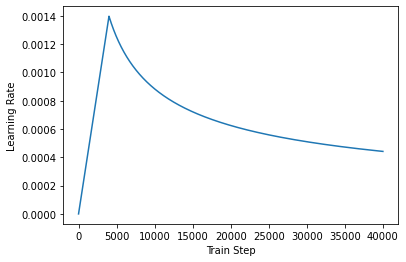

In [50]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

타겟 시퀀스에는 padding이 있는데, padding은 원래의 시퀀스에 포함되어 있지 않은 부분이기 때문에 loss를 구할 때 계산과정에서 제외해야합니다.

In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 
# from_logits=True: y_pred가 확률분포인 경우
# reduction='none': cross entropy loss를 각각 계산한 후 더하지 않음 (추후 padding 0에 해당하는 loss를 없애기 위해)

In [52]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask # padding 0에 해당하는 loss 제거
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [53]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 학습 및 모델 저장

In [54]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [55]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Checkpoint 경로와 checkpoint manager를 생성합니다. 매 `n` epoch 마다 모델이 저장됩니다.

In [56]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# max_to_keep: 저장되는 checkpoint 수
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


타겟은 tar_inp과 tar_real로 나누어집니다. tar_inp은 decoder의 입력값이고 `tar_real`은 tar_inp에서 오른쪽으로 한 칸 이동한 값입니다. Transformer의 출력값이 `tar_real`이 되도록 학습합니다. 즉 현재 단어가 주어졌을 때 바로 다음 단어를 예측하는 모델을 생성합니다.


예를 들면, `sentence` = "SOS A lion in the jungle is sleeping EOS" (SOS: start of sentence, start token, EOS: end of sentence, end token)

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

모델이 미래 단어를 보는 것을 막기 위해 `look-ahead mask`를 이용해 미래 단어를 가립니다.

In [57]:
EPOCHS = 10000

inp: Korean
tar: English
    tar_inp: 한글자 앞
    tar_real: 한글자 뒤

In [58]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

한국어가 입력 언어, 영어가 타겟 언어입니다.

In [59]:
%%time
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> korean, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1191 Accuracy 0.3482
Epoch 1 Batch 50 Loss 2.0305 Accuracy 0.3584
Epoch 1 Batch 100 Loss 2.0365 Accuracy 0.3583
Epoch 1 Batch 150 Loss 2.0355 Accuracy 0.3604
Epoch 1 Batch 200 Loss 1.9966 Accuracy 0.3654
Epoch 1 Batch 250 Loss 1.9504 Accuracy 0.3668
Epoch 1 Batch 300 Loss 1.8975 Accuracy 0.3682
Epoch 1 Batch 350 Loss 1.8475 Accuracy 0.3690
Epoch 1 Batch 400 Loss 1.8005 Accuracy 0.3688
Epoch 1 Batch 450 Loss 1.7626 Accuracy 0.3693
Epoch 1 Batch 500 Loss 1.7352 Accuracy 0.3695
Epoch 1 Batch 550 Loss 1.7157 Accuracy 0.3699
Epoch 1 Batch 600 Loss 1.7025 Accuracy 0.3701


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 9, in <module>
  File "/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 580, in __call__
    result = self._call(*args, **kwds)
  File "/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 611, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 2420, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: disable=protected-access
  File "/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/tensorflow/python/e

TypeError: object of type 'NoneType' has no len()

## 모델 평가

모델 평가 순서는 다음과 같습니다.

* 입력 문장(한국어)를 tokenizer를 이용해 쪼갭니다. 다음 start, end token을 문장 양 끝에 추가합니다.
* `Decoder` 입력값은 start token입니다.
* padding mask와 look ahead mask를 계산합니다.
* `Decoder`를 이용해 다음 단어 한 개를 예측합니다.
* 예측한 단어 한 개를 decoder 입력값과 합치고 다시 `Decoder`의 입력값으로 이용합니다.
* 즉 이전 단어들을 이용해 다음 단어를 예측합니다.
* End token이 나올때까지 이 과정을 반복합니다.

In [60]:
def evaluate(inp_sentence):
  start_token = [tokenizer_kr.vocab_size]
  end_token = [tokenizer_kr.vocab_size + 1]
  
  # inp sentence is Korean, hence adding the start and end token
  inp_sentence = start_token + tokenizer_kr.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  # MAX_LENGTH: 생성된 문장이 가질 수 있는 최대 길이
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # 마지막 단어만 선택합니다. decoder 입력값으로 넣은 단어들과 예측한 다음 단어를 합치기 위해서입니다.
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # end token이 생성되면 단어 생성을 멈추고 출력값으로 return합니다.
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # 마지막에 생성된 단어를 decoder의 입력값과 합칩니다. 이는 다음 루프의 decoder 입력값이 됩니다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [61]:
def plot_attention_weights(attention, sentence, result, layer):
  path = './fonts/NanumGothic.ttf'
  fontprop = fm.FontProperties(fname=path)

  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_kr.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_kr.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90, fontproperties=fontprop)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [62]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [63]:
%matplotlib inline

Input: 안녕하세요
Predicted translation: A boat takes it.



/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hanjy/anaconda3/envs/0812_transformer_bert/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


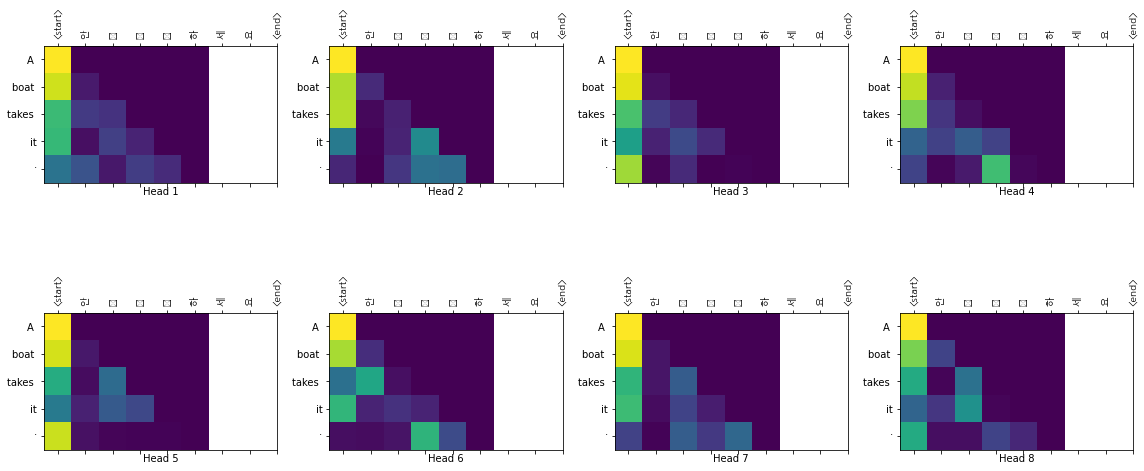

In [64]:
translate('안녕하세요', plot='decoder_layer4_block1')

Input: 퇴근하고싶다.
Predicted translation: He has a lot to do that.



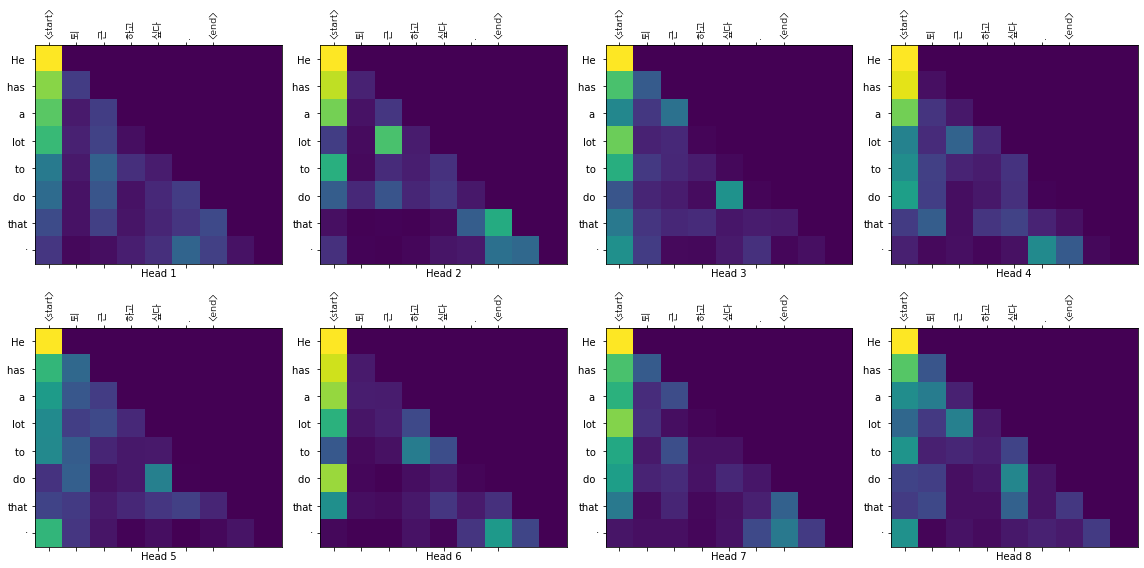

In [65]:
translate('퇴근하고싶다.', plot='decoder_layer4_block1')

Input: 한국 사람들은 업무가 끝나도 상관이 퇴근하기 전에는 사무실을 떠나려 하지 않는다.
Predicted translation: As many as one thing they do you get to return to the nation's capital, they said.



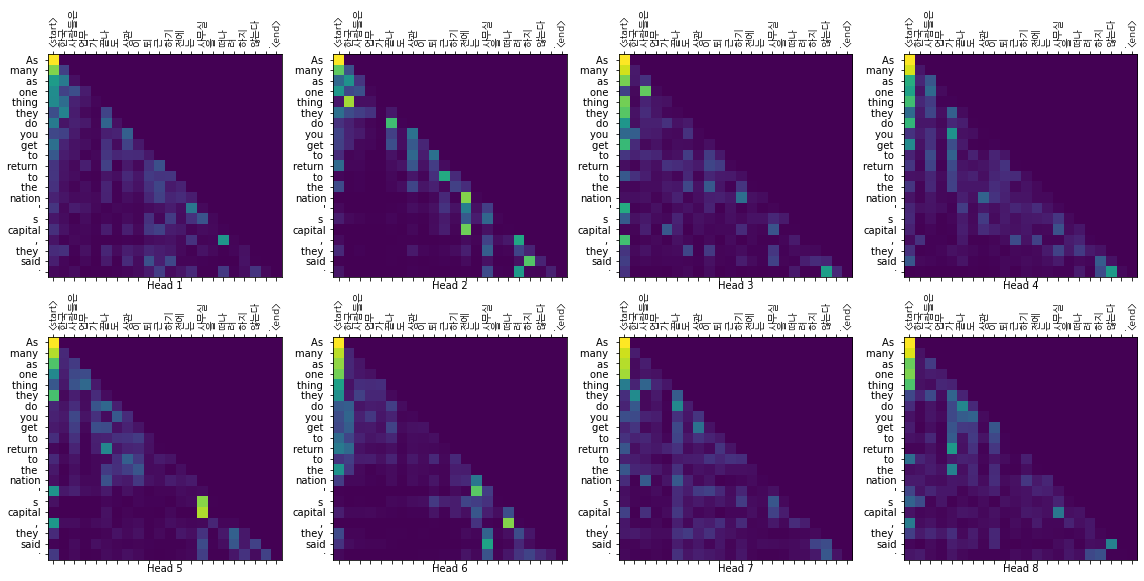

In [66]:
translate('한국 사람들은 업무가 끝나도 상관이 퇴근하기 전에는 사무실을 떠나려 하지 않는다.', plot='decoder_layer4_block1')

Input: Hello World!
Predicted translation: The fires.



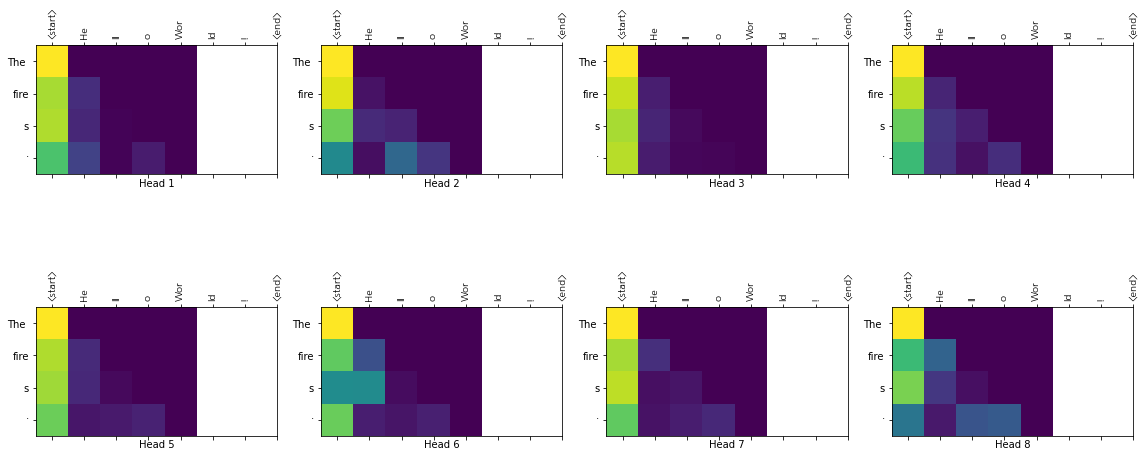

In [67]:
translate('Hello World!', plot='decoder_layer4_block1')

In [ ]:
translate('모든 광마우스와 마찬가지로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', plot='decoder_layer4_block1')

In [ ]:
tokenizer_en.encode('evidence')

In [ ]:
tokenizer_kr.encode('증거')

In [ ]:
translate('그러나 불충분한 증거 확보로 수사에 어려움이 있다.', plot='decoder_layer4_block1')